In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
# Set device
device = torch.device( "cuda")

# Load and preprocess the data
otu_table = pd.read_csv('genus_rotated_f_filtered.csv', header=0, index_col=None)

# Convert each row to percentage
otu_percentage = otu_table.div(otu_table.sum(axis=1), axis=0) * 100

# Set the number of bins
num_bins = 5

# Discretize the data
otu_discrete = otu_percentage.apply(lambda x: pd.cut(x, bins=num_bins, labels=range(1, num_bins + 1)), axis=1)
otu_discrete = otu_discrete.apply(pd.to_numeric)
# # Specify the path to save the CSV file
# output_path = 'otu_discrete_numeric.csv'

# # Save the DataFrame to a CSV file
# otu_discrete.to_csv(output_path, index=False)

# print(f'DataFrame saved to {output_path}')
# otu_table_scaled_df = pd.DataFrame(otu_discrete, columns=otu_table.columns)
# Convert the DataFrame to a torch tensor
otu_tensor = torch.tensor(otu_discrete.values, dtype=torch.float32)
otu_table_scaled_df = otu_tensor
# Define a function to randomly mask some features
def mask_features(tensor, mask_ratio=0.10):
    masked_tensor = tensor.clone()
    mask = torch.rand(tensor.shape) < mask_ratio
    masked_tensor[mask] = 0 # or use a specific token like -1
    return masked_tensor, mask

# Define the transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=8, num_layers=6):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, input_dim)
    
    def forward(self, x, return_features=False):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        if return_features:
            return x
        x = self.decoder(x)
        return x
input_dim = otu_table_scaled_df.shape[1]
pretrained_model  = TransformerModel(input_dim)


Epoch [1/256], Loss: 2.3783
Epoch [2/256], Loss: 2.1067
Epoch [3/256], Loss: 1.8956
Epoch [4/256], Loss: 1.6151
Epoch [5/256], Loss: 1.3655
Epoch [6/256], Loss: 1.0450
Epoch [7/256], Loss: 0.9719
Epoch [8/256], Loss: 0.9408
Epoch [9/256], Loss: 0.9655
Epoch [10/256], Loss: 0.7640
Epoch [11/256], Loss: 0.8020
Epoch [12/256], Loss: 0.7913
Epoch [13/256], Loss: 0.8420
Epoch [14/256], Loss: 0.6261
Epoch [15/256], Loss: 0.7962
Epoch [16/256], Loss: 0.7336
Epoch [17/256], Loss: 0.7739
Epoch [18/256], Loss: 0.6585
Epoch [19/256], Loss: 0.8830
Epoch [20/256], Loss: 0.6802
Epoch [21/256], Loss: 0.7597
Epoch [22/256], Loss: 0.6365
Epoch [23/256], Loss: 0.6392
Epoch [24/256], Loss: 0.6677
Epoch [25/256], Loss: 0.6417
Epoch [26/256], Loss: 0.5646
Epoch [27/256], Loss: 0.4729
Epoch [28/256], Loss: 0.6069
Epoch [29/256], Loss: 0.5150
Epoch [30/256], Loss: 0.6278
Epoch [31/256], Loss: 0.5269
Epoch [32/256], Loss: 0.4546
Epoch [33/256], Loss: 0.5196
Epoch [34/256], Loss: 0.4865
Epoch [35/256], Loss: 0

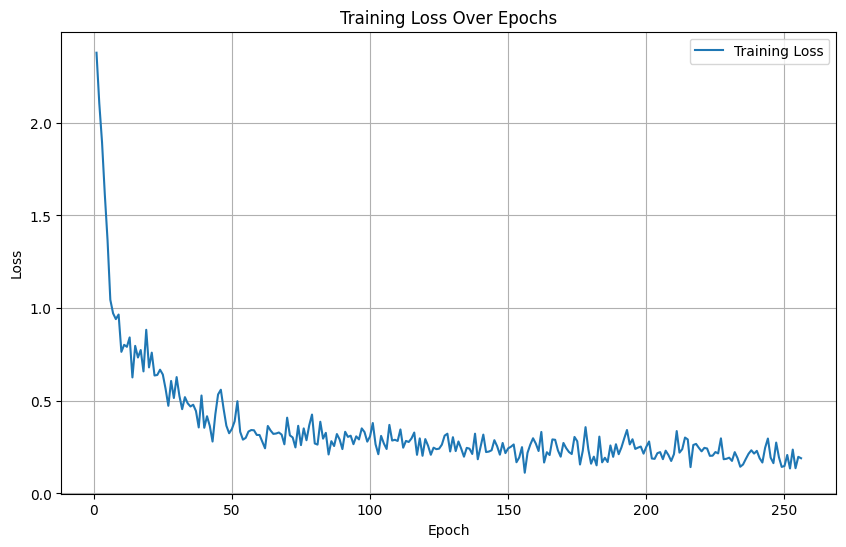

In [2]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.0001)

# Training loop
num_epochs = 256
mask_ratio = 0.10
loss_values = []

for epoch in range(num_epochs):
    pretrained_model.train()
    
    masked_tensor, mask = mask_features(otu_tensor, mask_ratio)
    
    optimizer.zero_grad()
    outputs = pretrained_model(masked_tensor)
    
    # Compute loss only for the masked positions
    loss = criterion(outputs[mask], otu_tensor[mask])
    loss.backward()
    optimizer.step()
    
    loss_values.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
plt.show()
torch.save(pretrained_model.state_dict(), 'pretrained_model.pth')